<a href="https://colab.research.google.com/github/Pranav24112004/ML_HCT/blob/main/Catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Catboost

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

print("All packages are working and ready!")

All packages are working and ready!


In [13]:
# 🧾 Step 1: Load the dataset
df = pd.read_csv('/content/output (4).csv')  # Reads the dataset into a pandas DataFrame

# 🎯 Step 2: Separate features (X) and target variable (y)
X = df.drop(columns=['efs_time'])  # Drop the target column to get the features
y = df['efs_time']  # Target variable (what we want to predict)

# 🧐 Step 3: Detect float columns that might be categorical
# Some float columns may represent categorical values (e.g., 0.0, 1.0, 2.0)
float_cols = X.select_dtypes(include=['float']).columns  # Get all float-type columns
for col in float_cols:
    if X[col].nunique() < 20:  # If a column has few unique values, consider it categorical
        X[col] = X[col].astype(str)  # Convert such columns to string (categorical)

# 🔍 Step 4: Identify categorical features
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()  # List of all categorical features

# 🔀 Step 5: Split the dataset into training and test sets
# Use 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🧠 Step 6: Initialize CatBoost regressor model
cat_model = CatBoostRegressor(verbose=0, random_state=42)



In [16]:
# 🛠️ Step 7: Define hyperparameters for tuning
'''
param_grid = {
    'depth': [4, 6, 8],  # Tree depth controls model complexity
    'learning_rate': [0.01, 0.05, 0.1],  # Step size for gradient descent
    'iterations': [300, 500, 700]  # Number of boosting iterations
}
'''
param_grid = {
    'depth': [4],  # Tree depth controls model complexity
    'learning_rate': [0.01],  # Step size for gradient descent
    'iterations': [300]  # Number of boosting iterations
}
# 🔍 Step 8: Set up GridSearchCV for hyperparameter tuning
# Using 3-fold cross-validation and RMSE as the performance metric (negated)
grid = GridSearchCV(
    cat_model,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    refit=True,
    verbose=1  # Show training progress
)

# 🚂 Step 9: Train the model using the training data
# Pass in categorical features so CatBoost can handle them appropriately
grid.fit(X_train, y_train, cat_features=cat_features)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7bcb012eab50>,
             param_grid={'depth': [4], 'iterations': [300],
                         'learning_rate': [0.01]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [17]:
# ✅ Step 10: Retrieve the best trained model (only one in this case)
best_model = grid.best_estimator_

# 🔮 Step 11: Make predictions on the test set
y_pred = best_model.predict(X_test)

# 📊 Step 12: Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared
mape = mean_absolute_percentage_error(y_test, y_pred)  # Mean Absolute Percentage Error

# 🖨️ Print the results
print("\n📊 Evaluation Metrics (depth=4, learning_rate=0.01, iterations=300):")
print(f"MAE  (Mean Absolute Error):        {mae:.3f}")
print(f"MSE  (Mean Squared Error):         {mse:.3f}")
print(f"RMSE (Root Mean Squared Error):    {rmse:.3f}")
print(f"R²   (R-squared Score):            {r2:.3f}")
print(f"MAPE (Mean Absolute % Error):      {mape:.3f}")


📊 Evaluation Metrics (depth=4, learning_rate=0.01, iterations=300):
MAE  (Mean Absolute Error):        5.523
MSE  (Mean Squared Error):         110.978
RMSE (Root Mean Squared Error):    10.535
R²   (R-squared Score):            0.822
MAPE (Mean Absolute % Error):      0.371


In [19]:
from catboost import cv
# 🛠️ Step 7: Create CatBoost Pool with categorical feature info
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

# 🧪 Step 8: Define model parameters
params = {
    'depth': 5,
    'learning_rate': 0.01,
    'iterations': 1000,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    'random_seed': 42,
    'verbose': 100
}

# 🔍 Step 9: Perform internal CV with early stopping
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=3,
    shuffle=True,
    partition_random_seed=42,
    plot=True
)

# 📊 Step 10: Train final model using best iteration from CV
best_iter = np.argmin(cv_results['test-RMSE-mean'])
print(f"\n📌 Best Iteration from CV: {best_iter}")

params['iterations'] = best_iter

final_model = CatBoostRegressor(**params)
final_model.fit(train_pool)

# 🔮 Step 11: Make predictions on test set
y_pred = final_model.predict(test_pool)

# 📈 Step 12: Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# 🖨️ Step 13: Print results
print("\n📊 Final Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error):        {mae:.3f}")
print(f"MSE  (Mean Squared Error):         {mse:.3f}")
print(f"RMSE (Root Mean Squared Error):    {rmse:.3f}")
print(f"R²   (R-squared Score):            {r2:.3f}")
print(f"MAPE (Mean Absolute % Error):      {mape:.3f}")

Training on fold [0/3]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 33.9727818	test: 32.8549501	best: 32.8549501 (0)	total: 285ms	remaining: 4m 44s
100:	learn: 16.2126970	test: 15.4681710	best: 15.4681710 (100)	total: 11.8s	remaining: 1m 45s
200:	learn: 11.5730645	test: 11.1476363	best: 11.1476363 (200)	total: 22.3s	remaining: 1m 28s
300:	learn: 10.5362742	test: 10.3051769	best: 10.3051769 (300)	total: 34.3s	remaining: 1m 19s
400:	learn: 10.2704566	test: 10.1197509	best: 10.1197509 (400)	total: 47.5s	remaining: 1m 10s
500:	learn: 10.1546054	test: 10.0508920	best: 10.0508920 (500)	total: 1m	remaining: 59.9s
600:	learn: 10.0691044	test: 10.0015269	best: 10.0015269 (600)	total: 1m 12s	remaining: 48.1s
700:	learn: 10.0042692	test: 9.9656814	best: 9.9656725 (697)	total: 1m 24s	remaining: 36.2s
800:	learn: 9.9540261	test: 9.9366776	best: 9.9366776 (800)	total: 1m 36s	remaining: 24.1s
900:	learn: 9.8935762	test: 9.8963256	best: 9.8963256 (900)	total: 1m 50s	remaining: 12.1s
999:	learn: 9.8345126	test: 9.8567093	best: 9.8567084 (998)	total: 2m 3s	rem

In [22]:
# 🎯 Step 2: Separate features (X) and log-transform the target variable (y)
X = df.drop(columns=['efs_time'])
y = np.log(df['efs_time'])  # Apply natural log transformation

In [23]:
# 🧐 Step 3: Detect float columns that might be categorical
float_cols = X.select_dtypes(include=['float']).columns
for col in float_cols:
    if X[col].nunique() < 20:
        X[col] = X[col].astype(str)

# 🔍 Step 4: Identify categorical features
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 🔀 Step 5: Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧠 Step 6: Initialize CatBoostRegressor
cat_model = CatBoostRegressor(verbose=0, random_state=42)

# 🛠️ Step 7: Hyperparameter grid (tuned down for faster run)
param_grid = {
    'depth': [4],
    'learning_rate': [0.01],
    'iterations': [300]
}

# 🔍 Step 8: GridSearchCV
grid = GridSearchCV(
    cat_model,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    refit=True,
    verbose=1
)

# 🚂 Step 9: Fit model
grid.fit(X_train, y_train, cat_features=cat_features)

# ✅ Step 10: Best model
best_model = grid.best_estimator_

# 🔮 Step 11: Predict (on log scale)
y_pred_log = best_model.predict(X_test)

# 🔄 Inverse log transformation
y_pred = np.exp(y_pred_log)
y_actual = np.exp(y_test)

# 📊 Step 12: Evaluation metrics
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred)

# 🖨️ Print results
print("\n📊 Evaluation Metrics (GridSearch model):")
print(f"MAE  (Mean Absolute Error):        {mae:.3f}")
print(f"MSE  (Mean Squared Error):         {mse:.3f}")
print(f"RMSE (Root Mean Squared Error):    {rmse:.3f}")
print(f"R²   (R-squared Score):            {r2:.3f}")
print(f"MAPE (Mean Absolute % Error):      {mape:.3f}")

# 🛠️ Step 13: Pool for CatBoost CV
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

# 🧪 Step 14: Model params for internal CV
params = {
    'depth': 5,
    'learning_rate': 0.01,
    'iterations': 1000,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    'random_seed': 42,
    'verbose': 100
}

# 🔍 Step 15: Perform internal cross-validation
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=3,
    shuffle=True,
    partition_random_seed=42,
    plot=True
)

# 📌 Step 16: Best iteration
best_iter = np.argmin(cv_results['test-RMSE-mean'])
print(f"\n📌 Best Iteration from CV: {best_iter}")

params['iterations'] = best_iter

# 🚀 Step 17: Train final model
final_model = CatBoostRegressor(**params)
final_model.fit(train_pool)

# 🔮 Step 18: Predict using final model
y_pred_log = final_model.predict(test_pool)

# 🔄 Inverse transform
y_pred = np.exp(y_pred_log)
y_actual = np.exp(y_test)

# 📈 Step 19: Final Evaluation
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred)

# 🖨️ Step 20: Print final results
print("\n📊 Final Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error):        {mae:.3f}")
print(f"MSE  (Mean Squared Error):         {mse:.3f}")
print(f"RMSE (Root Mean Squared Error):    {rmse:.3f}")
print(f"R²   (R-squared Score):            {r2:.3f}")
print(f"MAPE (Mean Absolute % Error):      {mape:.3f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits

📊 Evaluation Metrics (GridSearch model):
MAE  (Mean Absolute Error):        5.755
MSE  (Mean Squared Error):         135.983
RMSE (Root Mean Squared Error):    11.661
R²   (R-squared Score):            0.782
MAPE (Mean Absolute % Error):      0.293


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 2.7876740	test: 2.7642466	best: 2.7642466 (0)	total: 147ms	remaining: 2m 26s
100:	learn: 1.0971957	test: 1.0814856	best: 1.0814856 (100)	total: 8.37s	remaining: 1m 14s
200:	learn: 0.5466955	test: 0.5385321	best: 0.5385321 (200)	total: 16.6s	remaining: 1m 5s
300:	learn: 0.4050068	test: 0.4040145	best: 0.4040145 (300)	total: 27.8s	remaining: 1m 4s
400:	learn: 0.3730428	test: 0.3757991	best: 0.3757991 (400)	total: 40.3s	remaining: 1m
500:	learn: 0.3616493	test: 0.3666713	best: 0.3666713 (500)	total: 53.1s	remaining: 52.8s
600:	learn: 0.3552070	test: 0.3615447	best: 0.3615447 (600)	total: 1m 6s	remaining: 44s
700:	learn: 0.3508494	test: 0.3582501	best: 0.3582497 (699)	total: 1m 19s	remaining: 33.7s
800:	learn: 0.3478032	test: 0.3557643	best: 0.3557643 (800)	total: 1m 31s	remaining: 22.8s
900:	learn: 0.3449706	test: 0.3536593	best: 0.3536593 (900)	total: 1m 44s	remaining: 11.5s
999:	learn: 0.3418095	test: 0.3510620	best: 0.3510620 (999)	total: 1m 57s	remaini

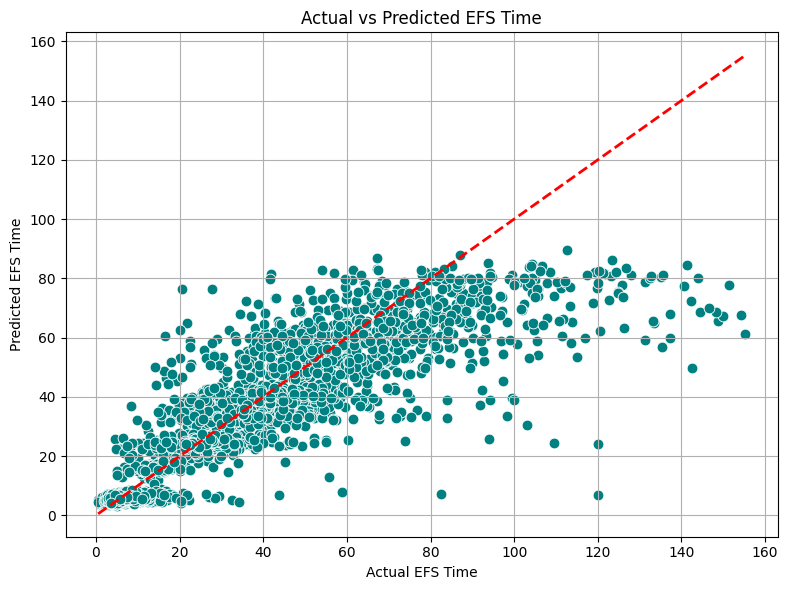

In [24]:
'''
📊 Final Evaluation Metrics:
MAE  (Mean Absolute Error):        5.090
MSE  (Mean Squared Error):         100.467
RMSE (Root Mean Squared Error):    10.023
R²   (R-squared Score):            0.839
MAPE (Mean Absolute % Error):      0.296
'''
'''
📊 Final Evaluation Metrics:
MAE  (Mean Absolute Error):        5.069
MSE  (Mean Squared Error):         106.521
RMSE (Root Mean Squared Error):    10.321
R²   (R-squared Score):            0.829
MAPE (Mean Absolute % Error):      0.257
'''
# 📊 Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_actual, y=y_pred, color='teal', edgecolor='w', s=60)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], '--r', linewidth=2)
plt.xlabel('Actual EFS Time')
plt.ylabel('Predicted EFS Time')
plt.title('Actual vs Predicted EFS Time')
plt.grid(True)
plt.tight_layout()
plt.show()